The purpose of this notebook is to show how to use the agn object and its pipelines. The agn object is a macromodel of the other classes designed to streamline calculations. It can host an accretion disk, a diffuse continuum, a torus, and multiple broad line regions (which may represent various ionic species). 

Setting up the agn object is the most important part, so we will start there. The default accretion disk is the Shakura + Sunyaev disk, though the Novikov + Thorne disk may also be implimented using "visc_temp_prof"="NT".

In [1]:
import numpy as np
import sys

sys.path.append("../src/")
from amoeba.Classes.agn import Agn
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt

In [2]:
# include some specific parameters for disk
my_agn_dictionary = {
    "smbh_mass_exp": 8.72,
    "redshift_source": 0.44,
    "inclination_angle": 38,
    "eddington_ratio": 0.04,
    "number_grav_radii": 2000,
    "resolution": 500,
    "corona_height": 20,
}
my_basic_agn = Agn("I'm number one!", **my_agn_dictionary)

Let's take a look at the AGN's current components!

In [3]:
print(my_basic_agn.components)

{}


Right now the macromodel is initialized, but has nothing inside. We can change that using some of its methods.

## Accretion disk implimentation

In [4]:
my_basic_agn.add_default_accretion_disk()
print(my_basic_agn.components)

{'accretion_disk': <amoeba.Classes.accretion_disk.AccretionDisk object at 0x139805490>}


Armed with our accretion disk embedded in the AGN, we can run all the usual accretion disk methods

In [5]:
embedded_disk = my_basic_agn.components["accretion_disk"]
wavelength = 500  # nm
flux_distribution = embedded_disk.calculate_surface_intensity_map(wavelength)
disk_transfer_function = embedded_disk.construct_accretion_disk_transfer_function(
    wavelength
)

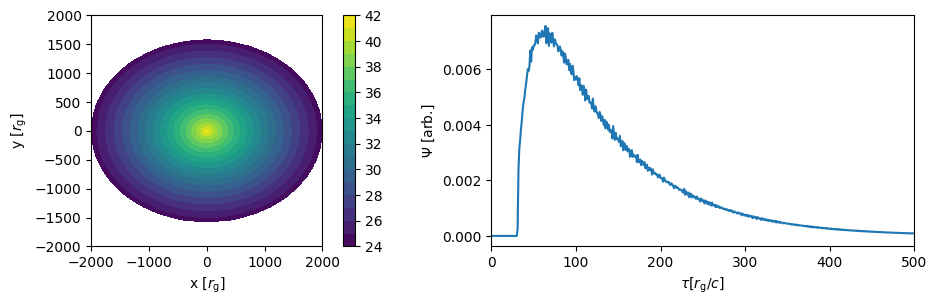

In [6]:
X, Y = flux_distribution.get_plotting_axes()
tau_ax = np.linspace(0, len(disk_transfer_function) - 1, len(disk_transfer_function))

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
contours = ax[0].contourf(X, Y, np.log10(flux_distribution.flux_array), 20)
cbar = plt.colorbar(contours, ax=ax[0])
ax[0].set_aspect(1)
ax[0].set_xlabel(r"x [$r_{\rm{g}}$]")
ax[0].set_ylabel(r"y [$r_{\rm{g}}$]")

ax[1].plot(tau_ax, disk_transfer_function)
fig.set_figheight(3)
ax[1].set_xlim(0, 500)
ax[1].set_xlabel(r"$\tau[r_{\rm{g}}/ c ]$")
ax[1].set_ylabel(r"$\Psi$ [arb.]")

plt.show()

Alternatively to extracting the accretion disk object, you can create these directly from the Agn object.

In [7]:
direct_flux_distribution = my_basic_agn.visualize_static_accretion_disk(wavelength)
direct_transfer_function = my_basic_agn.calculate_accretion_disk_transfer_function(
    wavelength
)

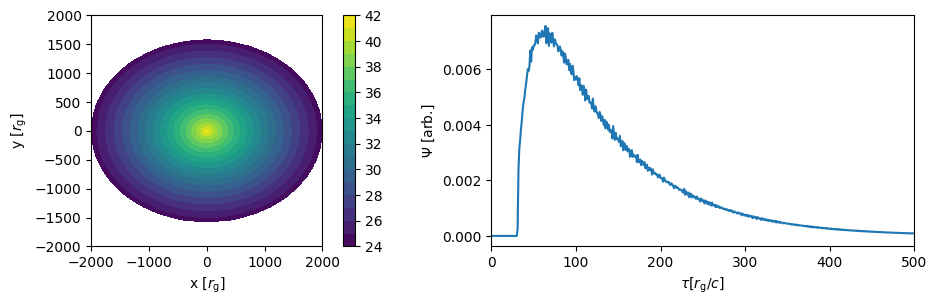

In [8]:
X, Y = direct_flux_distribution.get_plotting_axes()
tau_ax = np.linspace(
    0, len(direct_transfer_function) - 1, len(direct_transfer_function)
)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
contours = ax[0].contourf(X, Y, np.log10(direct_flux_distribution.flux_array), 20)
cbar = plt.colorbar(contours, ax=ax[0])
ax[0].set_aspect(1)
ax[0].set_xlabel(r"x [$r_{\rm{g}}$]")
ax[0].set_ylabel(r"y [$r_{\rm{g}}$]")

ax[1].plot(tau_ax, direct_transfer_function)
fig.set_figheight(3)
ax[1].set_xlim(0, 500)
ax[1].set_xlabel(r"$\tau[r_{\rm{g}}/ c ]$")
ax[1].set_ylabel(r"$\Psi$ [arb.]")


plt.show()

## Broad Line Region implimentation

Adding a broad line region (BLR) is a little more tricky, since we need to construct the streamlines to define the BLR.

In [9]:
from amoeba.Classes.blr_streamline import Streamline
from amoeba.Classes.blr import BroadLineRegion

In [10]:
max_blr_height = 500  # rg
rest_frame_wavelength_in_nm = 388  # nm
my_blr_dictionary = {
    "max_height": max_blr_height,
    "rest_frame_wavelength_in_nm": rest_frame_wavelength_in_nm,
    "radial_step": 50,
    "height_step": 50,
}
my_basic_agn.add_blr(**my_blr_dictionary)
for item in my_basic_agn.components:
    print(item)

accretion_disk
blr_0


Note that an index has been appended to the blr. This is to keep track of various blr objects within the AGN, and by default index "0" is selected. Let's add a second blr.

In [11]:
rest_frame_wavelength_in_nm_2 = 710  # nm
my_blr_dictionary = {
    "max_height": max_blr_height,
    "rest_frame_wavelength_in_nm": rest_frame_wavelength_in_nm_2,
    "radial_step": 50,
    "height_step": 50,
}
blr_index = 88.2
my_basic_agn.add_blr(blr_index=blr_index, **my_blr_dictionary)
for item in my_basic_agn.components:
    print(item)

accretion_disk
blr_0
blr_88.2


If you've used the blr object before, you may be reminded that these are just initializations. The emitting region must be added to each of these after initialization with streamlines. Streamlines follow the Yang et. al prescription.

In [12]:
inner_launch_radius = 2000  # rg
inner_launch_angle = 20  # degrees
inner_characteristic_distance = (
    200  # rg, defines the acceleration of the material along the streamline
)
inner_asymptotic_velocity = 0.05  # v/c, defines maximum velocity along streamline

inner_streamline = Streamline(
    inner_launch_radius,
    inner_launch_angle,
    max_blr_height,
    inner_characteristic_distance,
    inner_asymptotic_velocity,
    height_step=50
)
outer_launch_radius = 3000  # rg
outer_launch_angle = 40  # degrees
outer_characteristic_distance = (
    200  # rg, defines the acceleration of the material along the streamline
)
outer_asymptotic_velocity = 0.05  # v/c, defines maximum velocity along streamline

outer_streamline = Streamline(
    outer_launch_radius,
    outer_launch_angle,
    max_blr_height,
    outer_characteristic_distance,
    outer_asymptotic_velocity,
    height_step=50
)

my_blr_streamlines_0 = {
    "InnerStreamline": inner_streamline,
    "OuterStreamline": outer_streamline,
}

far_outer_launch_radius = 3100  # rg
far_outer_launch_angle = 45  # degrees
far_outer_characteristic_distance = (
    200  # rg, defines the acceleration of the material along the streamline
)
far_outer_asymptotic_velocity = 0.2  # v/c, defines maximum velocity along streamline

far_outer_streamline = Streamline(
    far_outer_launch_radius,
    far_outer_launch_angle,
    max_blr_height,
    far_outer_characteristic_distance,
    far_outer_asymptotic_velocity,
    height_step=50
)

my_blr_streamlines_882 = {
    "InnerStreamline": outer_streamline,
    "OuterStreamline": far_outer_streamline,
}

In [13]:
my_basic_agn.add_streamline_bounded_region_to_blr(blr_index=0, **my_blr_streamlines_0)
my_basic_agn.add_streamline_bounded_region_to_blr(
    blr_index=88.2, **my_blr_streamlines_882
);

Now that the embedded BLR are set up within the AGN, we may visualize its projection.

In [14]:
projection_blr_0 = my_basic_agn.visualize_static_blr(blr_index=0)
projection_blr_882 = my_basic_agn.visualize_static_blr(blr_index=88.2)

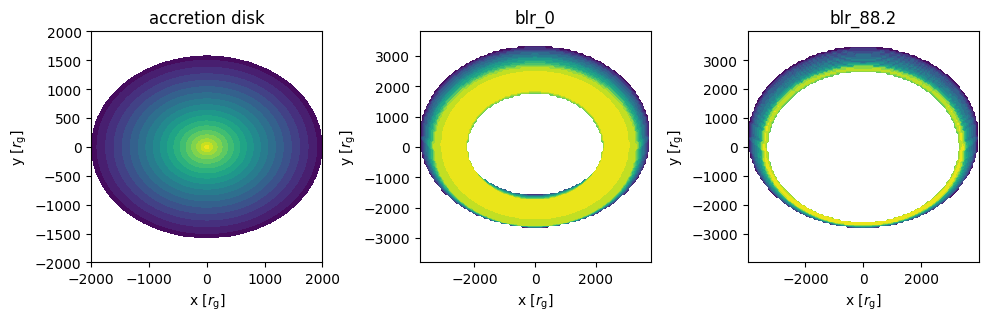

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

X, Y = direct_flux_distribution.get_plotting_axes()
ax[0].contourf(X, Y, np.log10(direct_flux_distribution.flux_array), 20)
ax[0].set_title("accretion disk")

X, Y = projection_blr_0.get_plotting_axes()
ax[1].contourf(X, Y, np.log10(projection_blr_0.flux_array), 20)
ax[1].set_title("blr_0")

X, Y = projection_blr_882.get_plotting_axes()
ax[2].contourf(X, Y, np.log10(projection_blr_882.flux_array), 20)
ax[2].set_title("blr_88.2")

for axis in ax:
    axis.set_aspect(1)
    axis.set_xlabel(r"x [$r_{\rm{g}}$]")
    axis.set_ylabel(r"y [$r_{\rm{g}}$]")


plt.show()

Let's say we want to use this system and change our point of view. As long as the accretion disk is a basic type, you can simply update parameters with the set of update methods. This will in turn update all component models of the AGN.

In [16]:
new_inclination = 60

my_basic_agn.update_inclination(new_inclination)

direct_flux_distribution = my_basic_agn.visualize_static_accretion_disk(wavelength)
projection_blr_0 = my_basic_agn.visualize_static_blr(blr_index=0)
projection_blr_882 = my_basic_agn.visualize_static_blr(blr_index=88.2)

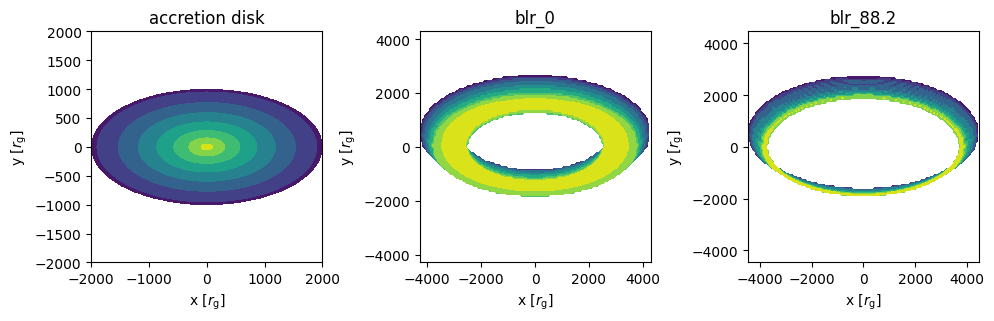

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

X, Y = direct_flux_distribution.get_plotting_axes()
ax[0].contourf(X, Y, np.log10(direct_flux_distribution.flux_array))
ax[0].set_title("accretion disk")

X, Y = projection_blr_0.get_plotting_axes()
ax[1].contourf(X, Y, np.log10(projection_blr_0.flux_array))
ax[1].set_title("blr_0")

X, Y = projection_blr_882.get_plotting_axes()
ax[2].contourf(X, Y, np.log10(projection_blr_882.flux_array))
ax[2].set_title("blr_88.2")

for axis in ax:
    axis.set_aspect(1)
    axis.set_xlabel(r"x [$r_{\rm{g}}$]")
    axis.set_ylabel(r"y [$r_{\rm{g}}$]")


plt.show()

The blr projections shown are technically the integrated flux over all wavelengths. We can instead select coponents which become projected into specific wavelength ranges or filters.

In [18]:
from speclite.filters import load_filter

filter_1 = load_filter("lsst2023-g")
projection_blr_0_1 = my_basic_agn.visualize_static_blr(
    blr_index=0, speclite_filter=filter_1
)
projection_blr_882_1 = my_basic_agn.visualize_static_blr(
    blr_index=88.2, speclite_filter=filter_1
)
filter_2 = load_filter("lsst2023-y")
projection_blr_0_2 = my_basic_agn.visualize_static_blr(
    blr_index=0, speclite_filter=filter_2
)
projection_blr_882_2 = my_basic_agn.visualize_static_blr(
    blr_index=88.2, speclite_filter=filter_2
)

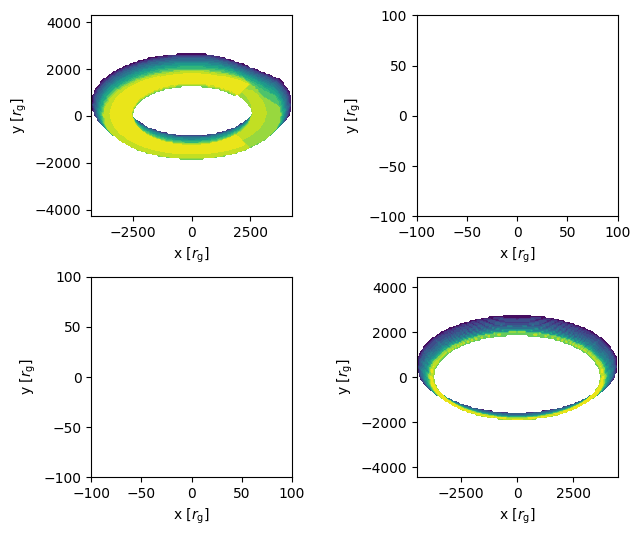

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(7, 6))

# in the top row, plot BLR with index 0
X, Y = projection_blr_0_1.get_plotting_axes()
ax[0, 0].contourf(X, Y, np.log10(projection_blr_0_1.flux_array), 20)
X, Y = projection_blr_0_2.get_plotting_axes()
ax[0, 1].contourf(X, Y, np.log10(projection_blr_0_2.flux_array), 20)

# in the bottom row, plot BLR with index 88.2
X, Y = projection_blr_882_1.get_plotting_axes()
ax[1, 0].contourf(X, Y, np.log10(projection_blr_882_1.flux_array), 20)
X, Y = projection_blr_882_2.get_plotting_axes()
ax[1, 1].contourf(X, Y, np.log10(projection_blr_882_2.flux_array), 20)

# left column is filter_1, right column is filter_2

for axax in ax:
    for axis in axax:
        axis.set_aspect(1)
        axis.set_xlabel(r"x [$r_{\rm{g}}$]")
        axis.set_ylabel(r"y [$r_{\rm{g}}$]")
plt.subplots_adjust(hspace=0.3, wspace=0.5)

plt.show()

## Diffuse continuum implimentation

The diffuse continuum (DC) is believed to contribute to the reverberation properties of the AGN. We will show how a toy model may be implimented, which may be adjusted with any expected or calculated emission properties. This follows the Korista + Goad procedure for a given time delay spectrum.

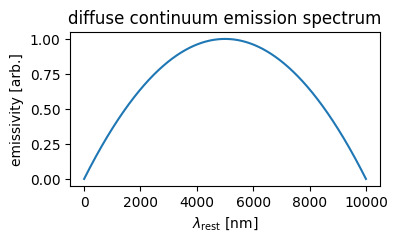

In [20]:
dc_wavelengths = np.linspace(1, 10000, 10000)
dc_emissivities = dc_wavelengths * np.flip(dc_wavelengths)  # some basic quadratic
dc_emissivities /= np.max(dc_emissivities)  # normalize

diffuse_continuum_kwargs = {
    "cloud_density_radial_dependence": 0,
    "r_in_in_gravitational_radii": inner_launch_radius,
    "r_out_in_gravitational_radii": far_outer_launch_radius,
    "rest_frame_wavelengths": dc_wavelengths,
    "responsivity_constant": 0.5,
    "emissivity_etas": dc_emissivities,
}

my_basic_agn.add_diffuse_continuum(**diffuse_continuum_kwargs)

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(dc_wavelengths, dc_emissivities)
ax.set_title("diffuse continuum emission spectrum")
ax.set_xlabel(r"$\lambda_{\rm{rest}}$ [nm]")
ax.set_ylabel("emissivity [arb.]")
plt.show()

We can project the emission of the diffuse continuum just like each other component

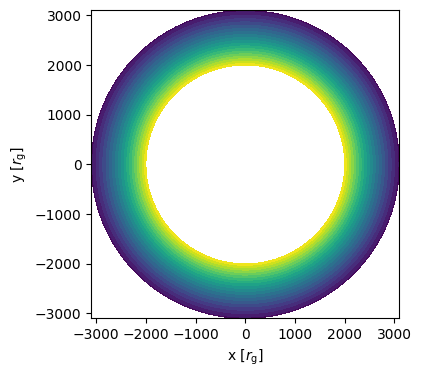

In [21]:
my_diffuse_continuum_emission = my_basic_agn.visualize_static_diffuse_continuum(500)
fig, ax = plt.subplots(figsize=(4, 4))
X, Y = my_diffuse_continuum_emission.get_plotting_axes()

ax.contourf(X, Y, np.log10(my_diffuse_continuum_emission.flux_array), 20)
ax.set_xlabel(r"x [$r_{\rm{g}}$]")
ax.set_ylabel(r"y [$r_{\rm{g}}$]")
ax.set_aspect(1)
plt.show()

Currently, there is not torus emission implimented. However, when this update is provided it will have a small tutorial here.

## Visualization pipeline

Going through each of these components one by one just to see what they look like can get tedious. This is why a visualization pipeline is created in order to create all components with one method. The structure of the AGN is important for microlensing studies which probe the detailed structure of the source. Let's update the wavelength, redshift, and inclination first.

In [22]:
my_basic_agn.update_inclination(28)
my_basic_agn.update_redshift(2.1)
# recall the blr was initialized at rest frame 388 and 710 nm.

wavelength_ranges = [
    [1000, 1300],
    [2000, 2100],
]  # in nm, any number of ranges may be given.

visualization = my_basic_agn.visualize_agn_pipeline(
    observer_frame_wavelengths_in_nm=wavelength_ranges
)

In [23]:
print(np.shape(visualization))
print(type(visualization[0]))

(2,)
<class 'amoeba.Classes.flux_projection.FluxProjection'>


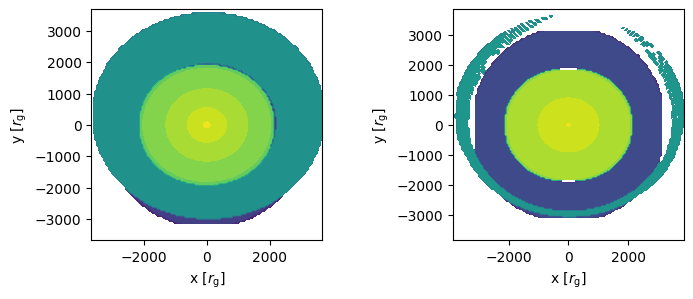

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
X, Y = visualization[0].get_plotting_axes()
ax[0].contourf(X, Y, np.log10(visualization[0].flux_array), 20)

X, Y = visualization[1].get_plotting_axes()
ax[1].contourf(X, Y, np.log10(visualization[1].flux_array), 20)

for axis in ax:
    axis.set_aspect(1)
    axis.set_xlabel(r"x [$r_{\rm{g}}$]")
    axis.set_ylabel(r"y [$r_{\rm{g}}$]")
plt.subplots_adjust(wspace=0.4)
plt.show()

The accretion disk dominates the flux and the other components are not very interesting. Note that the diffuse continuum is assumed to be some radial distribution of clouds independent of inclination angle, so it does not project like the other components.

We can instead project each piece independenly.

In [25]:
component_projections = my_basic_agn.visualize_agn_pipeline(
    observer_frame_wavelengths_in_nm=wavelength_ranges, return_components=True
)

In [26]:
print(np.shape(component_projections))

(2, 3)


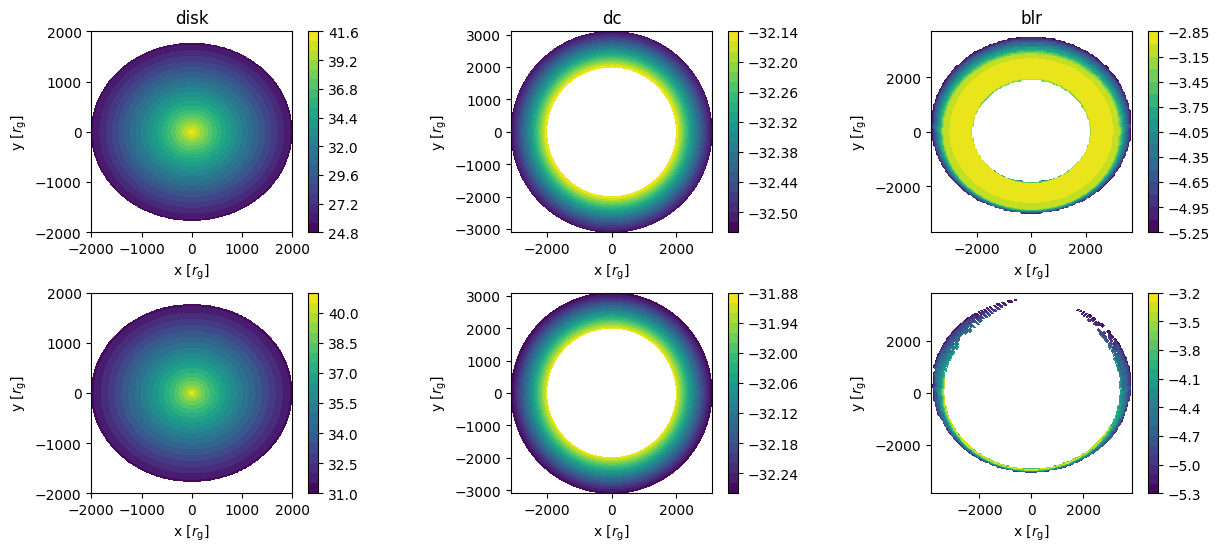

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

for row, wavelength_range in enumerate(component_projections):
    for column, current_flux_projection in enumerate(wavelength_range):
        X, Y = current_flux_projection.get_plotting_axes()
        cur_conts = ax[row, column].contourf(
            X, Y, np.log10(current_flux_projection.flux_array), 20
        )
        plt.colorbar(cur_conts, ax=ax[row, column])
        ax[row, column].set_xlabel(r"x [$r_{\rm{g}}$]")
        ax[row, column].set_ylabel(r"y [$r_{\rm{g}}$]")
        ax[row, column].set_aspect(1)

ax[0, 0].set_title("disk")
ax[0, 1].set_title("dc")
ax[0, 2].set_title("blr")

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

And now once again for a new inclination

In [28]:
my_basic_agn.update_inclination(38)

component_projections = my_basic_agn.visualize_agn_pipeline(
    observer_frame_wavelengths_in_nm=wavelength_ranges, return_components=True
)

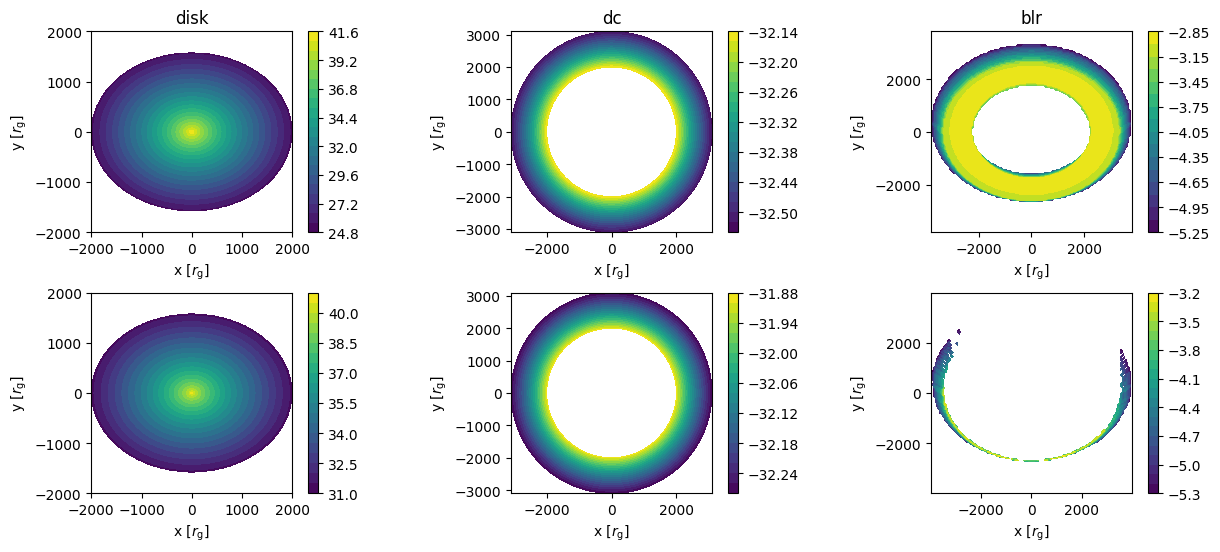

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

for row, wavelength_range in enumerate(component_projections):
    for column, current_flux_projection in enumerate(wavelength_range):
        X, Y = current_flux_projection.get_plotting_axes()
        cur_conts = ax[row, column].contourf(
            X, Y, np.log10(current_flux_projection.flux_array), 20
        )
        plt.colorbar(cur_conts, ax=ax[row, column])
        ax[row, column].set_xlabel(r"x [$r_{\rm{g}}$]")
        ax[row, column].set_ylabel(r"y [$r_{\rm{g}}$]")
        ax[row, column].set_aspect(1)

ax[0, 0].set_title("disk")
ax[0, 1].set_title("dc")
ax[0, 2].set_title("blr")

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

Let us now see this agn across a set of speclite filters

In [30]:
my_basic_agn.update_inclination(45)
my_basic_agn.update_redshift(0.2)

lsst_projections = my_basic_agn.visualize_agn_pipeline(speclite_filter="lsst2023-*")
labels = ["u", "g", "r", "i", "z", "y"]

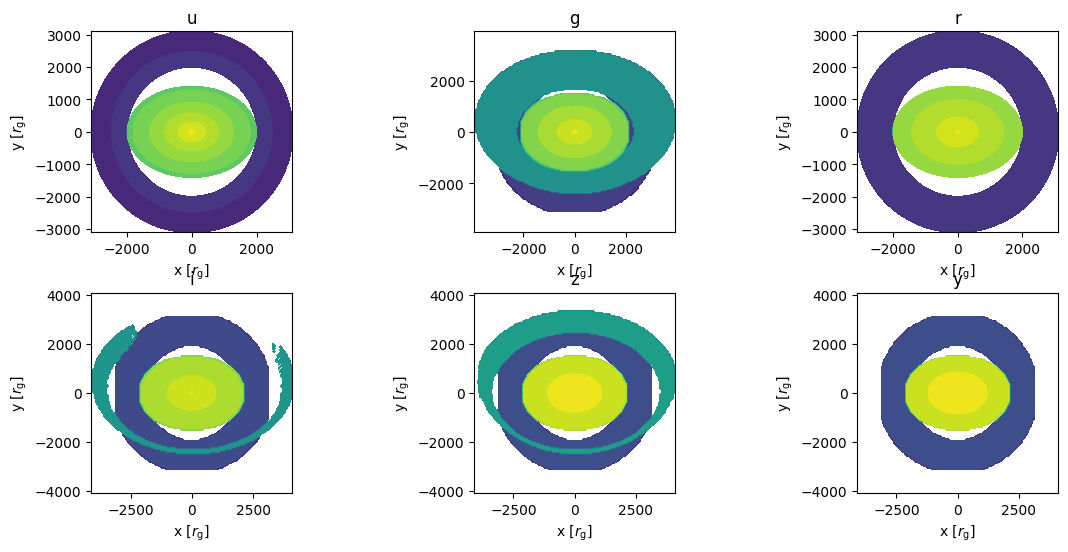

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))


for jj in range(len(lsst_projections)):
    X, Y = lsst_projections[jj].get_plotting_axes()
    ax[jj // 3, jj % 3].contourf(X, Y, np.log10(lsst_projections[jj].flux_array), 20)
    ax[jj // 3, jj % 3].set_title(labels[jj])

for row in ax:
    for axis in row:
        axis.set_aspect(1)
        axis.set_xlabel(r"x [$r_{\rm{g}}$]")
        axis.set_ylabel(r"y [$r_{\rm{g}}$]")

plt.subplots_adjust(hspace=0.3)
plt.show()

The flux distribution of each component is important for microlensing studies, since these must be treated consistenty. Note that the total contribution of each component will have to be scaled as needed.

## Reverberation pipeline

Another important probe of AGN is studying their variability. Time scales of reverberation can effectively constrain the size of the source, and time lags can provide an estimate for how distant components are. Accurately measured interband time lags has the ability to probe the continuum source's structure through reverberation mapping. First, we must prepare a signal to propogate through the system.

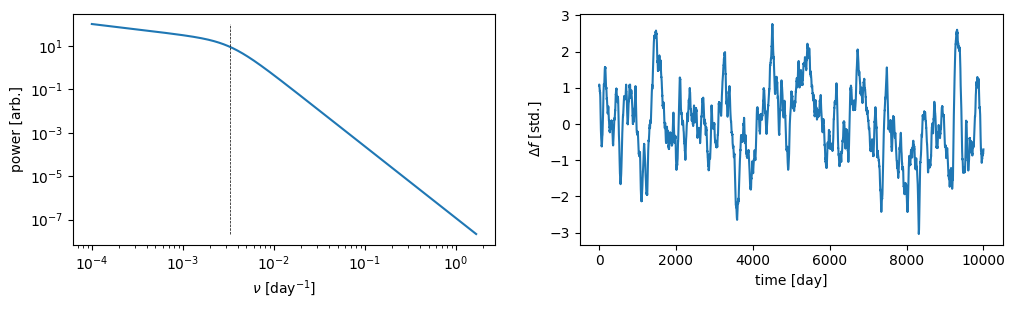

In [32]:
from amoeba.Util.util import generate_signal_from_psd

max_time = 10000  # days
sample_cadence = 0.3  # days
random_seed = int(4287 * 82384)

low_frequency_limit = 1 / (max_time)  # You can't probe frequencies greater than this
high_frequency_limit = 1 / (2 * sample_cadence)  # Nyquist frequency
n_frequencies = int(max_time / sample_cadence)

# create a bending power law
frequencies = np.linspace(low_frequency_limit, high_frequency_limit, n_frequencies)

bpl_low_freq_dependence = 0.5
bpl_high_freq_dependence = 3.3
time_scale_breakpoint = 300

power_spectrum = frequencies ** (-bpl_low_freq_dependence) * (
    1
    + (frequencies * time_scale_breakpoint)
    ** (bpl_high_freq_dependence - bpl_low_freq_dependence)
) ** (-1)

my_time_axis, my_driving_time_series = generate_signal_from_psd(
    max_time, power_spectrum, frequencies, random_seed=random_seed
)

# visualize power spectrum and generated signal

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].loglog(frequencies, power_spectrum)
ax[0].plot(
    [1 / time_scale_breakpoint, 1 / time_scale_breakpoint],
    [np.min(power_spectrum), np.max(power_spectrum)],
    "--",
    color="black",
    linewidth=0.5,
)
ax[0].set_xlabel(r"$\nu$ [day$^{-1}$]")
ax[0].set_ylabel("power [arb.]")
ax[1].plot(my_time_axis, my_driving_time_series)
ax[1].set_xlabel("time [day]")
ax[1].set_ylabel(r"$\Delta f$ [std.]")  # units of standard deviations

plt.show()

Note that the signal generated is set to have a mean value of 0 and a standard deviation of 1. This makes it easy to adopt to systems with different variability properties. However, this also means that the generated power law does not have any physical units along its y axis.

We can plug this signal directly into the AGN model we've built up and sample it in various filters. Note that this is the most time consuming part of this notebook. The intrinsic signal propagation pipeline must compute the transfer function for each component at each wavelength, which is 4 * 6 = 24 components. The BLR components take the longest time due to the volume integral over the top hemisphere of the AGN. Some shortcuts are taken when the BLR is expected to not contribute to a wavelength, which in our case reduces the calculation by 7 calculations. BLR_0 only contributes to the u and g bands, while BLR_882 only contributes to i, z, y bands.

In [33]:
pipeline_output = my_basic_agn.intrinsic_signal_propagation_pipeline(
    intrinsic_light_curve=my_driving_time_series,
    time_axis=my_time_axis,
    speclite_filter="lsst2023-*",
)

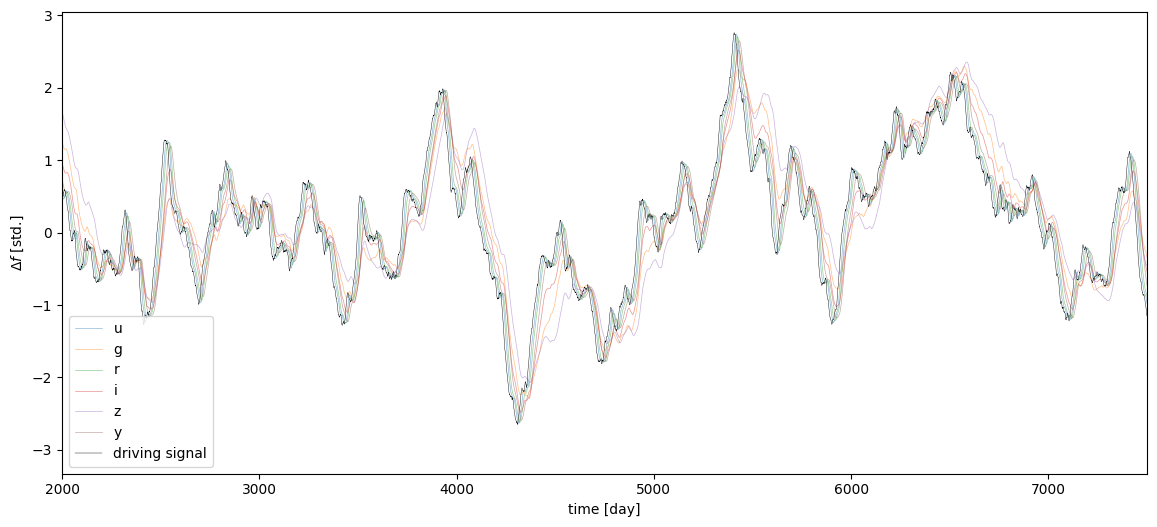

In [34]:
fig, ax = plt.subplots(figsize=(14, 6))

for jj in range(6):
    t_ax = pipeline_output[jj][0]
    signal = pipeline_output[jj][1]
    ax.plot(t_ax, signal / np.std(signal), linewidth=0.5, alpha=0.5, label=labels[jj])
ax.plot(
    my_time_axis * (1 + my_basic_agn.redshift_source),
    my_driving_time_series,
    linewidth=0.3,
    alpha=1,
    color="black",
    label="driving signal",
)

ax.legend(loc=3)
ax.set_xlim(2000, 7500)  # adjust to zoom on features as desired
ax.set_xlabel("time [day]")
ax.set_ylabel(r"$\Delta f$ [std.]")
plt.show()

The two most contaminated bands (by the BLR) are the g and z bands. This is as expected since the BLR_0 and BLR_882 primarily project into these, respectively. A notice will be printed when there is no contribution to a band (hence the 8 messages above), BLR_0 and BLR_882 project into 2 bands each, leaving us (6 * 2) - 4 = 8 messages. 

The components of the BLR exist in physically distinct regions, giving them different effective time lags. We can run the pipeline again to extract each component of the light curves.

In [35]:
pipeline_components = my_basic_agn.intrinsic_signal_propagation_pipeline(
    intrinsic_light_curve=my_driving_time_series,
    time_axis=my_time_axis,
    speclite_filter="lsst2023-*",
    return_components=True,
)

The components are a list of [reprocessed_signals, blr_signals, output_signals], where reprocessed_signals is a list of continuum signals for each wavelength/filter, blr_signals is a list of BLR reprocessed signals (if applicable), and output_signals is the same output as pipeline_output.

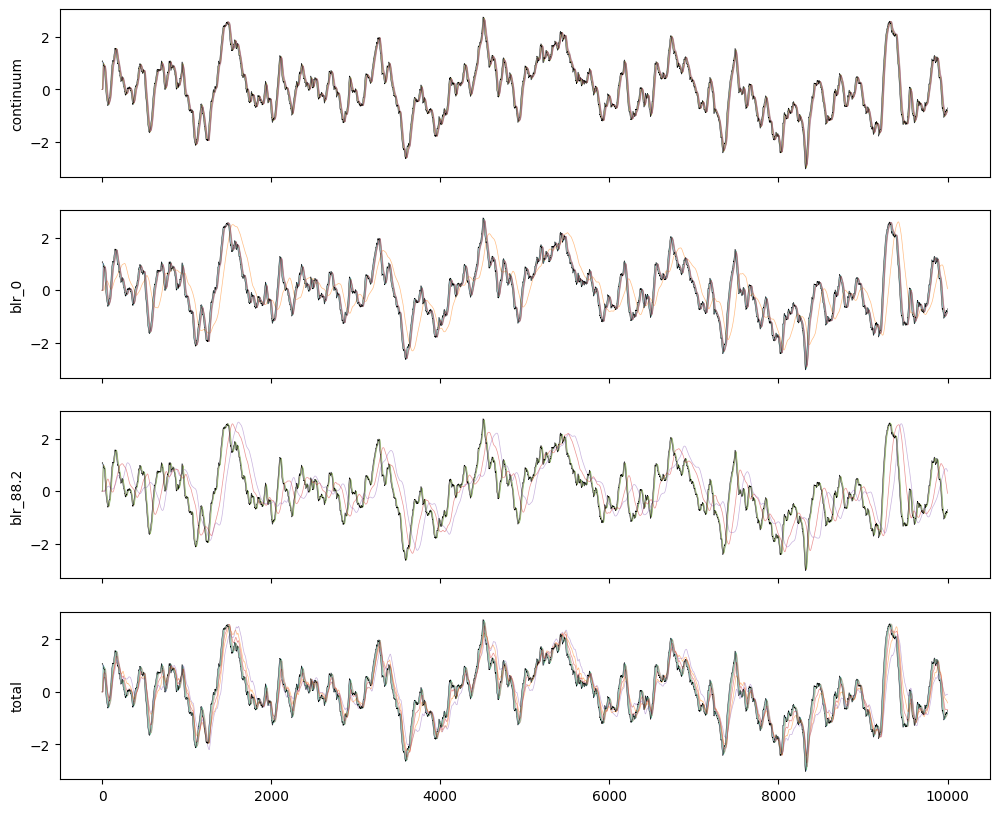

In [36]:
continuum_signals = pipeline_components[0]
blr_signals_0 = pipeline_components[1]["0"]
blr_signals_882 = pipeline_components[1]["88.2"]
component_wise_output = pipeline_components[2]

fig, ax = plt.subplots(4, figsize=(12, 10), sharex=True)

for jj in range(6):
    if (
        np.sum(np.asarray(continuum_signals[jj][0])) > 0
    ):  # to avoid dividing by zero for certain BLR signals
        ax[0].plot(
            continuum_signals[jj][0],
            continuum_signals[jj][1] / np.std(continuum_signals[jj][1]),
            alpha=0.5,
            linewidth=0.5,
            label=labels[jj],
        )
    else:
        ax[0].plot([0], [0], alpha=0.5, linewidth=0.5, label=labels[jj])
ax[0].plot(
    my_time_axis,
    my_driving_time_series,
    linewidth=0.3,
    alpha=1,
    color="black",
    label="driving signal",
)


for jj in range(6):
    if (
        np.sum(np.asarray(blr_signals_0[jj][0])) > 0
    ):  # to avoid dividing by zero for certain BLR signals
        ax[1].plot(
            blr_signals_0[jj][0],
            blr_signals_0[jj][1] / np.std(blr_signals_0[jj][1]),
            alpha=0.5,
            linewidth=0.5,
            label=labels[jj],
        )
    else:
        ax[1].plot([0], [0], alpha=0.5, linewidth=0.5, label=labels[jj])
ax[1].plot(
    my_time_axis,
    my_driving_time_series,
    linewidth=0.3,
    alpha=1,
    color="black",
    label="driving signal",
)

for jj in range(6):
    if (
        np.sum(np.asarray(blr_signals_882[jj][0])) > 0
    ):  # to avoid dividing by zero for certain BLR signals
        ax[2].plot(
            blr_signals_882[jj][0],
            blr_signals_882[jj][1] / np.std(blr_signals_882[jj][1]),
            alpha=0.5,
            linewidth=0.5,
            label=labels[jj],
        )
    else:
        ax[2].plot(
            blr_signals_882[jj][0],
            blr_signals_882[jj][1],
            alpha=0.5,
            linewidth=0.5,
            label=labels[jj],
        )
ax[2].plot(
    my_time_axis,
    my_driving_time_series,
    linewidth=0.3,
    alpha=1,
    color="black",
    label="driving signal",
)

for jj in range(6):
    if (
        np.sum(np.asarray(component_wise_output[jj][0])) > 0
    ):  # to avoid dividing by zero for certain BLR signals
        ax[3].plot(
            component_wise_output[jj][0] / (1 + my_basic_agn.redshift_source),
            component_wise_output[jj][1] / np.std(component_wise_output[jj][1]),
            alpha=0.5,
            linewidth=0.5,
            label=labels[jj],
        )
    else:
        ax[3].plot(
            component_wise_output[jj][0] / (1 + my_basic_agn.redshift_source),
            component_wise_output[jj][1],
            alpha=0.5,
            linewidth=0.5,
            label=labels[jj],
        )
ax[3].plot(
    my_time_axis,
    my_driving_time_series,
    linewidth=0.3,
    alpha=1,
    color="black",
    label="driving signal",
)


ax[0].set_ylabel("continuum")
ax[1].set_ylabel("blr_0")
ax[2].set_ylabel("blr_88.2")
ax[3].set_ylabel("total")


plt.show()

We can see that individual components reverberate with different timescales. Note that by default, each (full) BLR is assumed to contribute approximately the same flux as the continuum. This can be changed using the "line_strength" parameter in the Agn.add_blr() method. It is then scaled by the fraction of the BLR emitting region which falls inside the filter or wavelength range. This may be updated via the Agn.update_line_strength() method.

In [37]:
my_basic_agn.update_line_strength(blr_index=88.2, new_line_strength=0.3)
my_basic_agn.update_line_strength(0, 10)

True

In [38]:
new_pipeline_output = my_basic_agn.intrinsic_signal_propagation_pipeline(
    intrinsic_light_curve=my_driving_time_series,
    speclite_filter="lsst2023-*",
    return_components=False,
)

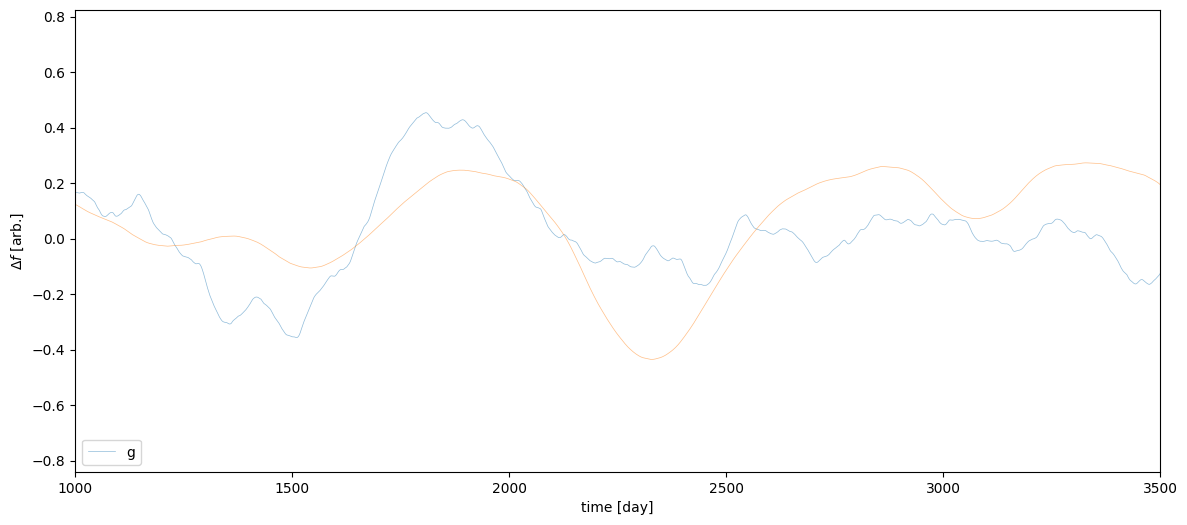

In [39]:
fig, ax = plt.subplots(figsize=(14, 6))

for jj in range(6):
    t_ax = pipeline_output[jj][0]
    if jj == 1:
        ax.plot(
            t_ax, pipeline_output[jj][1], linewidth=0.5, alpha=0.5, label=labels[jj]
        )
# ax.set_prop_cycle(None)
for jj in range(6):
    t_ax_2 = new_pipeline_output[jj][0]
    if jj == 1:
        ax.plot(t_ax_2, new_pipeline_output[jj][1], linewidth=0.5, alpha=0.5)


ax.legend(loc=3)
ax.set_xlim(1000, 3500)  # adjust to zoom on features as desired
ax.set_xlabel("time [day]")
ax.set_ylabel(r"$\Delta f$ [arb.]")
plt.show()

This notebook will be updated as modifications to the code are made! Thank you again for trying Amoeba out, and please forward all bug reports and suggestions to the Github repository or hbest@gradcenter.cuny.edu